# Improvements to HierQ

 - Relative Goal Spaces
 - Optional Goal-Conditioning of top-level.

In [1]:
# Reload dependencies upon changes
%load_ext autoreload
%autoreload 2

#### Libraries

In [2]:
from functools import partial
import typing
import sys

import numpy as np
import gym
import tqdm
import matplotlib.pyplot as plt

from mazelab_experimenter import EnvRegister
from mazelab_experimenter import AgentShelve
from mazelab_experimenter import evaluate, GenericOuterHook, benchmark
from mazelab_experimenter.utils import find

In [3]:
AgentShelve.get_types()

['TabularQLearner',
 'TabularQLearnerN',
 'TabularQLambda',
 'TabularQET',
 'TabularDynaQ',
 'MonteCarloQLearner',
 'RandomAgent',
 'HierQ',
 'HierQV2',
 'HierQN',
 'HierQTD',
 'HierQTS',
 'HierQLambda']

In [4]:
AgentShelve.get_keyword_args('HierQV2')

<Signature (observation_shape: 'typing.Tuple', n_actions: 'int', n_levels: 'int', horizons: 'typing.Union[typing.List[int]]', discount: 'float' = 0.95, lr: 'float' = 0.5, epsilon: 'float' = 0.1, lr_decay: 'float' = 0.0, greedy_options: 'bool' = False, relative_actions: 'bool' = False, relative_goals: 'bool' = False, universal_top: 'bool' = False, shortest_path_rewards: 'bool' = False, sarsa: 'bool' = False, stationary_filtering: 'bool' = True, hindsight_goals: 'bool' = True, legal_states: 'np.ndarray' = None, **kwargs) -> 'None'>

In [5]:
t = 1000

name_four_rooms = EnvRegister.register(
    maze_type='four_rooms_HierQ', 
    name=f'four_rooms_hierq-v0', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[3, 8]]
    ),
    time_limit=t,
    override=True
)

name_gridworld = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld_hierq-v0', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(height=12, width=12),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[10, 10]]
    ),
    time_limit=t,
    override=True
)

Warning, room_size and gap_size are best kept as uniformly odd or even, not one odd one even.


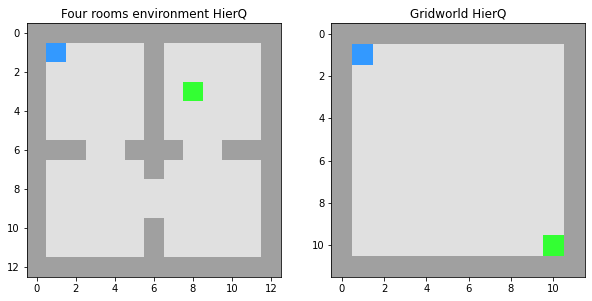

In [6]:
# Instantiate the registered MazeLab environment as a Gym environment.
four_rooms = gym.make(name_four_rooms)
gridworld = gym.make(name_gridworld)

# Illustrate the randomly generated maze. 
_ = four_rooms.reset(), gridworld.reset()

img_a, img_b = four_rooms.unwrapped.get_image(), gridworld.unwrapped.get_image()

four_rooms.close()
gridworld.close()

f, axarr = plt.subplots(1, 2, figsize=(10, 5))

axarr[0].imshow(img_a)
axarr[0].set_title("Four rooms environment HierQ")

axarr[1].imshow(img_b)
axarr[1].set_title("Gridworld HierQ")

plt.show()

In [7]:
def gen_hierq(n_levels: int, horizon: int, _env: gym.Env, universal_top: bool = True, relative_goals: bool = False):
    # Helper function for instantiating a HierQ agent with a fixed environment goal.
    agent = AgentShelve.retrieve(
        agent='HierQV2',
        keyword_arguments=dict(
            observation_shape=_env.observation_space.shape,
            n_actions=_env.action_space.n,
            n_levels=n_levels,
            horizons=[horizon] * (n_levels - 1) + [200],
            lr=1, discount=1, epsilon=0.25, 
            universal_top=universal_top, relative_goals=relative_goals
        ))
    agent.set_goal(agent._get_index(_env.unwrapped.maze.get_end_pos()[0]))
    return agent


def get_agent_gen(_env_name: str):
    # Wrapper function for instantiating the agent generator with an environment dependency.
    dummy = gym.make(_env_name)
    return [
        lambda: abs_hierq_l2(_env=dummy),
        lambda: abs_hierq_l3(_env=dummy),
        lambda: rel_abs_hierq_l2(_env=dummy),
        lambda: rel_abs_hierq_l3(_env=dummy)
    ]

abs_hierq_l2 = partial(gen_hierq, n_levels=2, horizon=3, universal_top=False)
abs_hierq_l3 = partial(gen_hierq, n_levels=3, horizon=3, universal_top=False)

gcabs_hierq_l2 = partial(gen_hierq, n_levels=2, horizon=3)
gcabs_hierq_l3 = partial(gen_hierq, n_levels=3, horizon=3)

rel_abs_hierq_l2 = partial(gen_hierq, n_levels=2, horizon=3, universal_top=False, relative_goals=True)
rel_abs_hierq_l3 = partial(gen_hierq, n_levels=3, horizon=3, universal_top=False, relative_goals=True)

rel_gcabs_hierq_l2 = partial(gen_hierq, n_levels=2, horizon=3, relative_goals=True)
rel_gcabs_hierq_l3 = partial(gen_hierq, n_levels=3, horizon=3, relative_goals=True)

In [8]:
# Benchmark configuration
r = 5
it = 100
eps = 1
trials = 10
verbose = True

# Benchmark data for each agent.
benchmark_data = list()
for env_name in [name_four_rooms, name_gridworld]:
    
    env_data = list()
    for agent_gen in get_agent_gen(env_name):
        # Run the benchmark
        env_data.append(
            benchmark(
                env_id=env_name, 
                _agent_gen=agent_gen, 
                agent_test_kwargs=dict(behaviour_policy=False),
                agent_train_kwargs=dict(),
                num_repetitions=r,
                num_iterations=it,
                num_episodes=eps,
                num_trials=trials,
                evaluation_hooks=[GenericOuterHook()],
                verbose=verbose,
                asynchronous=False
            )
        )
    benchmark_data.append((env_name, env_data))

-- Benchmarking Repetition 1 / 5 --- ETA:  --- Rate: 0 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]
-- Benchmarking Repetition 2 / 5 --- ETA: 0:01:54 --- Rate: 28 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.39it/s]
-- Benchmarking Repetition 3 / 5 --- ETA: 0:01:30 --- Rate: 30 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]
-- Benchmarking Repetition 4 / 5 --- ETA: 0:00:59 --- Rate: 29 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.27it/s]
-- Benchmarking Repetition 5 / 5 --- ETA: 0:00:30 --- Rate: 30 sec/ it
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]
-- Benchmarking Repetition 1 / 5 --- ETA:  --- Rate: 

## Plot Results

In [18]:
def plot_progress(arr: np.ndarray, population_size: int, axis: int = 0, label: str = None) -> None:
    # Helper function for plotting.
    mean_length = arr[...,axis][...,0].mean(axis=0)
    std_length = arr[...,axis][...,0].std(axis=0) / np.sqrt(population_size)

    plt.plot(mean_length, label=label, linewidth=2)
    plt.fill_between(np.arange(len(mean_length)), mean_length + std_length, mean_length - std_length, alpha=0.1)
    
    
def manhattan_dist(c_a: np.ndarray, c_b: np.ndarray):
    # Helper function to compute the L1 distance between two arrays.
    return np.sum(np.abs(np.asarray(c_a) - np.asarray(c_b)))

#### Four-Rooms

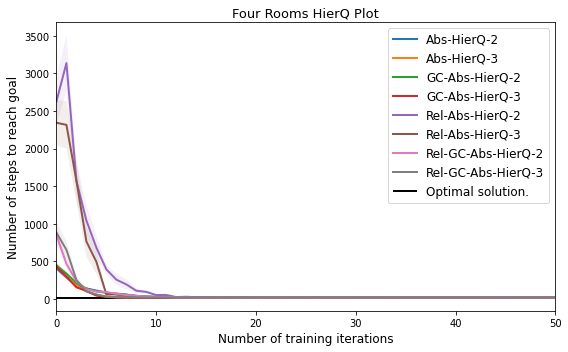

In [19]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'GC-Abs-HierQ-2', r'GC-Abs-HierQ-3', 
                                       r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3', r'Rel-GC-Abs-HierQ-2', r'Rel-GC-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(19, 0, 50, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 50])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

#### GridWorld

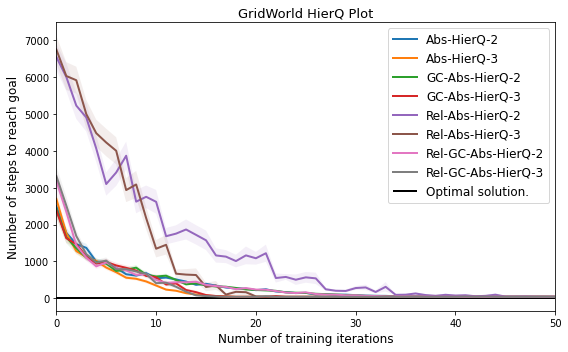

In [20]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HierQ-2', r'Abs-HierQ-3', r'GC-Abs-HierQ-2', r'GC-Abs-HierQ-3', 
                                       r'Rel-Abs-HierQ-2', r'Rel-Abs-HierQ-3', r'Rel-GC-Abs-HierQ-2', r'Rel-GC-Abs-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(gridworld.unwrapped.maze.get_start_pos(), gridworld.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 50, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 50])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

## Notepad

In [12]:
EnvRegister.get_keyword_args('n_rooms_square')

<Signature (num_rooms: int, room_size: int, gap_size: int) -> numpy.ndarray>

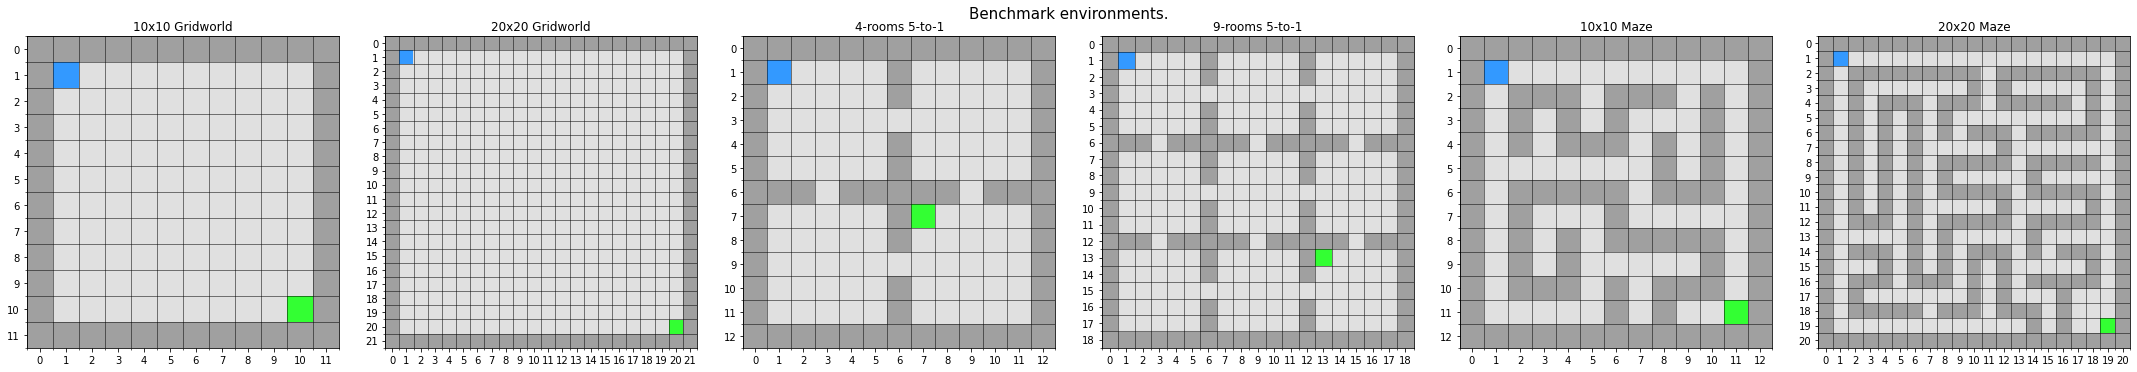

In [8]:
t = 10_000  # Number of steps before terminating an episode for any agent on all environments.
# t = 1_000

name_grid10 = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(height=12, width=12),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[10, 10]]
    ),
    time_limit=t,
    override=True
)

name_grid20 = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld-v1', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(height=22, width=22),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[20, 20]]
    ),
    time_limit=t,
    override=True
)

name_rooms4 = EnvRegister.register(
    maze_type='n_rooms_square', 
    name=f'n_rooms-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(num_rooms=4, room_size=5, gap_size=1),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[7, 7]]
    ),
    time_limit=t,
    override=True
)

name_rooms9 = EnvRegister.register(
    maze_type='n_rooms_square', 
    name=f'n_rooms-v1', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(num_rooms=9, room_size=5, gap_size=1),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[13, 13]]
    ),
    time_limit=t,
    override=True
)

name_mazeS = EnvRegister.register(
    maze_type='fixed_maze', 
    name=f'maze-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(large=False),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[11, 11]]
    ),
    time_limit=t,
    override=True
)

name_mazeL = EnvRegister.register(
    maze_type='fixed_maze', 
    name=f'maze-v1', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(large=True),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[19, 19]]
    ),
    time_limit=t,
    override=True
)

# Collect each individual environment.
environment_names = [name_grid10, name_grid20, name_rooms4, name_rooms9, name_mazeS, name_mazeL]
environment_labels = ['10x10 Gridworld', '20x20 Gridworld', '4-rooms 5-to-1', '9-rooms 5-to-1', '10x10 Maze', '20x20 Maze']

# Create and show an example visualization of the environment
dummy_images = list()
for name in environment_names:
    dummy = gym.make(name)
    dummy.reset()
    
    dummy_images.append(dummy.unwrapped.get_image())
    dummy.close()
    
fig, ax = plt.subplots(1, len(environment_names), figsize=(5 * len(environment_names), 5))
for i, img in enumerate(dummy_images):
    # Plot image with border padding
    ax[i].imshow(img)
    
    # Grid lines
    major, minor = np.arange(0, len(img), 1), np.arange(-.5, len(img), 1)
    ax[i].set_xticks(major); ax[i].set_yticks(major)            # Major plot ticks
    ax[i].set_xticklabels(major); ax[i].set_yticklabels(major)  # Major plot tick-labels
    ax[i].set_xticks(minor, minor=True); ax[i].set_yticks(minor, minor=True)  # Minor ticks for Grid-lines.
    
    ax[i].grid(which='minor', color='black', linestyle='-', linewidth=.5)
    
    # Annotations
    ax[i].set_title(environment_labels[i])

plt.suptitle("Benchmark environments.", fontsize=15)
plt.tight_layout()

plt.show()

In [10]:
def gen_hierq(n_levels: int, horizon: int, _env: gym.Env, universal_top: bool = True, relative_goals: bool = False, shortest_path_rewards: bool = True):
    # Helper function for instantiating a HierQ agent with a fixed environment goal.
    agent = AgentShelve.retrieve(
        agent='HierQV2',
        keyword_arguments=dict(
            observation_shape=_env.observation_space.shape,
            n_actions=_env.action_space.n,
            n_levels=n_levels,
            horizons=[horizon] * (n_levels - 1) + [200],
            lr=1, discount=(1 if shortest_path_rewards else 0.95), epsilon=0.25, 
            universal_top=universal_top, relative_goals=relative_goals,
            shortest_path_rewards=shortest_path_rewards
        ))
    agent.set_goal(agent._get_index(_env.unwrapped.maze.get_end_pos()[0]))
    return agent


def get_agent_gen(_env_name: str):
    # Wrapper function for instantiating the agent generator with an environment dependency.
    dummy = gym.make(_env_name)
    return [
        partial(abs_hierq_l2, _env=dummy, shortest_path_rewards=False),
        partial(abs_hierq_l3, _env=dummy, shortest_path_rewards=False),
        partial(rel_abs_hierq_l2, _env=dummy, shortest_path_rewards=False),
        partial(rel_abs_hierq_l3, _env=dummy, shortest_path_rewards=False),
        partial(abs_hierq_l2, _env=dummy, shortest_path_rewards=True),
        partial(abs_hierq_l3, _env=dummy, shortest_path_rewards=True),
        partial(rel_abs_hierq_l2, _env=dummy, shortest_path_rewards=True),
        partial(rel_abs_hierq_l3, _env=dummy, shortest_path_rewards=True),
    ]

abs_hierq_l2 = partial(gen_hierq, n_levels=2, horizon=3, universal_top=False, relative_goals=False)
abs_hierq_l3 = partial(gen_hierq, n_levels=3, horizon=3, universal_top=False, relative_goals=False)

rel_abs_hierq_l2 = partial(gen_hierq, n_levels=2, horizon=3, universal_top=False, relative_goals=True)
rel_abs_hierq_l3 = partial(gen_hierq, n_levels=3, horizon=3, universal_top=False, relative_goals=True)

In [13]:
# Benchmark configuration
r = 100
it = 100
eps = 1
trials = 1
verbose = True

# Benchmark data for each agent.
benchmark_data = list()
for env_name in environment_names:
    print("Experiment environment:", env_name)
    
    env_data = list()
    for i, agent_gen in enumerate(get_agent_gen(env_name)):
        print(f"Benchmarking agent: {i}")
        
        # Run the benchmark
        env_data.append(
            benchmark(
                env_id=env_name, 
                _agent_gen=agent_gen, 
                agent_test_kwargs=dict(behaviour_policy=False),
                agent_train_kwargs=dict(),
                skip_random_evaluation=True,
                num_repetitions=r,
                num_iterations=it,
                num_episodes=eps,
                num_trials=trials,
                evaluation_hooks=[GenericOuterHook()],
                verbose=verbose,
                asynchronous=False
            )
        )
    benchmark_data.append((env_name, env_data))

Experiment environment: gridworld-v0
Benchmarking agent: 0
-- Benchmarking Repetition 1 / 100 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.43it/s]
-- Benchmarking Repetition 2 / 100 --- ETA: 0:02:27 --- Rate: 1 sec/ it --- Total: 0.02 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 58.21it/s]
-- Benchmarking Repetition 3 / 100 --- ETA: 0:02:37 --- Rate: 1 sec/ it --- Total: 0.05 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 77.82it/s]
-- Benchmarking Repetition 4 / 100 --- ETA: 0:02:25 --- Rate: 1 sec/ it --- Total: 0.07 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 66.84it/s]
-- Benchmarking Repetition 5 / 100 --- ETA: 0:02:23 --- Rate: 1 sec/ it --- Total: 0.10 min
Train-Te

In [16]:
import pickle
with open('HierQV2.out', 'wb') as f:
    pickle.dump(benchmark_data, f)

## Plot

In [27]:
def plot_expectation(canvas, xs: np.ndarray, ydata: np.ndarray, repetition_size: int, axis: int = 0, label: str = None, color: str = None, style: str = None) -> None:
    # Helper function for plotting the mean performance with approximation error of the mean.
    mean = ydata[...,axis][..., 0].mean(axis=0)
    stderr = ydata[...,axis][..., 0].std(axis=0) / np.sqrt(repetition_size)

    canvas.plot(xs, mean, label=label, linewidth=2, linestyle=style, color=color)
    canvas.fill_between(xs, mean + stderr, mean - stderr, alpha=0.1, color=color)
    

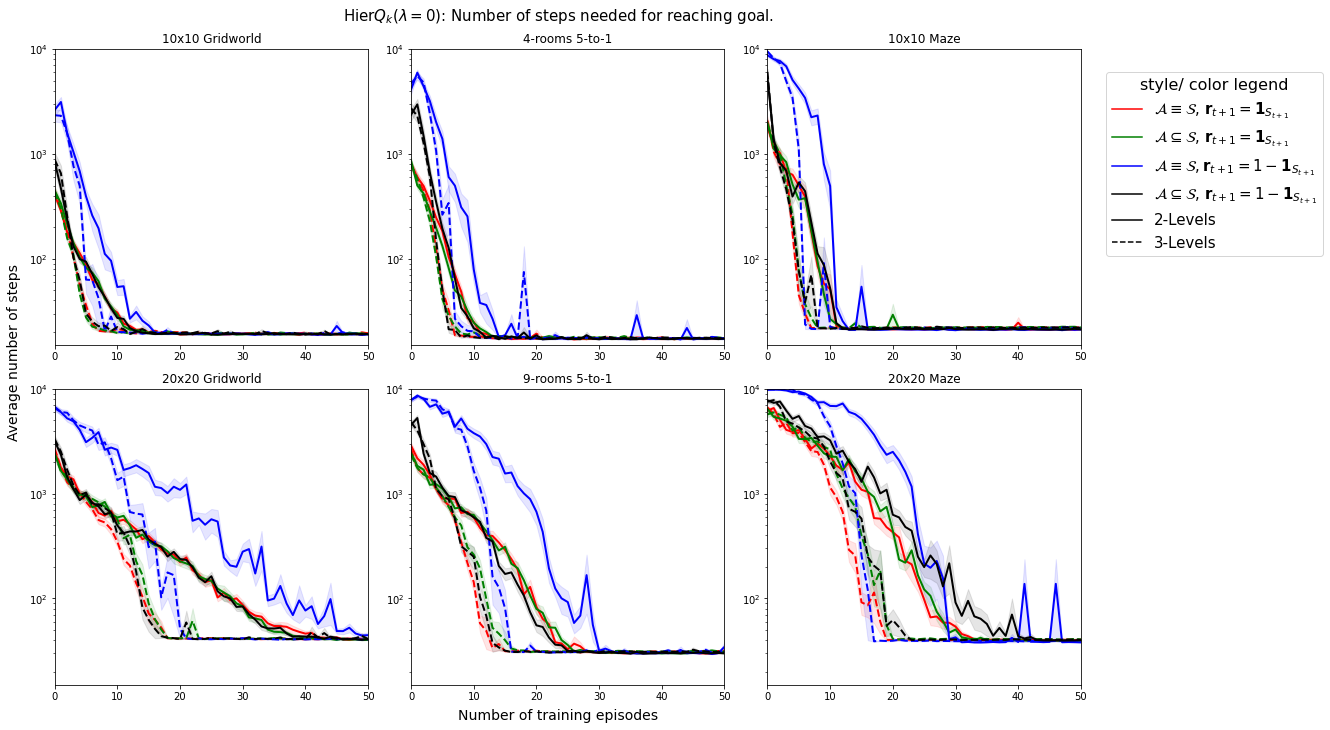

In [92]:

# Create figure
fig, ax = plt.subplots(2, 3, figsize=(15, 10))


colors = np.repeat(['red', 'green', 'blue', 'black'], 2)
styles = ['-', '--'] * 8
axis = 2
for env_i, env_data in enumerate(benchmark_data):
    canvas = ax[env_i % 2, env_i // 2]
    
    name, data = env_data
    for param_i, arr in enumerate(data):

        xs = np.arange(100)
        
        plot_expectation(canvas, xs, np.asarray(arr), 100, axis, style=styles[param_i], color=colors[param_i])
        canvas.set_title(environment_labels[env_i])
        canvas.set_yscale('log')
        canvas.set_xlim([0, 50])
        canvas.set_ylim([15, 10**4])

    
# Add Legend
plt.plot([], [], color='red', label=r'$\mathcal{A} \equiv \mathcal{S}$, $\mathbf{r}_{t+1} = \mathbf{1}_{S_{t+1}}$')
plt.plot([], [], color='green', label=r'$\mathcal{A} \subseteq \mathcal{S}$, $\mathbf{r}_{t+1} = \mathbf{1}_{S_{t+1}}$')
plt.plot([], [], color='blue', label=r'$\mathcal{A} \equiv \mathcal{S}, \mathbf{r}_{t+1} = 1 - \mathbf{1}_{S_{t+1}}$')
plt.plot([], [], color='black', label=r'$\mathcal{A} \subseteq \mathcal{S}$, $\mathbf{r}_{t+1} = 1 - \mathbf{1}_{S_{t+1}}$')

plt.plot([], [], linestyle='-', color='black', label=r'2-Levels')
plt.plot([], [], linestyle='--', color='black', label=r'3-Levels')

fig.legend(fontsize=15, ncol=1, title='style/ color legend', bbox_to_anchor=(1.0, 0.9), loc='upper left', title_fontsize=16)
    
# Plot annotations
fig.text(0.5, -0.01, 'Number of training episodes', fontsize=14, ha='center')
fig.text(-0.01, 0.5, 'Average number of steps', fontsize=14, va='center', rotation='vertical')
    
plt.suptitle(r"Hier$Q_k(\lambda = 0)$: Number of steps needed for reaching goal.", fontsize=15)

plt.tight_layout()
plt.show()

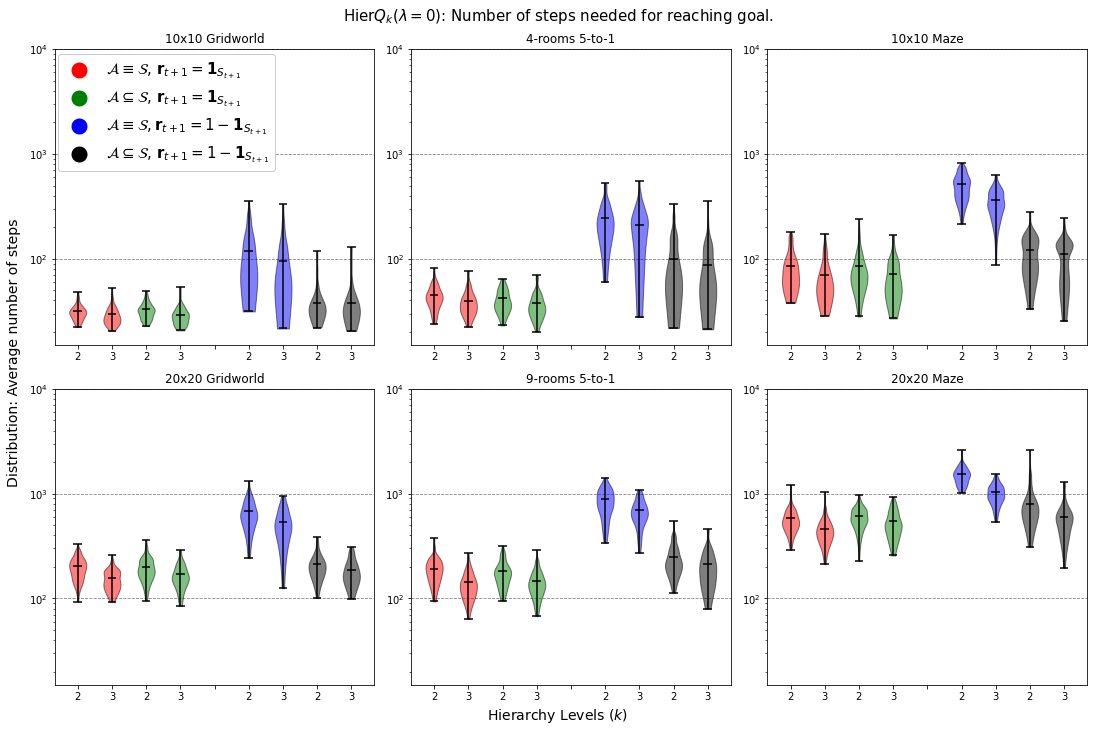

In [171]:
# Create figure
fig, ax = plt.subplots(2, 3, figsize=(15, 10))


colors = np.repeat(['red', 'green', 'blue', 'black'], 2)
styles = ['-', '--'] * 8
texts = [2, 3] * 2 + [''] + [2, 3] * 2
axis = 2
for env_i, env_data in enumerate(benchmark_data):
    canvas = ax[env_i % 2, env_i // 2]
    
    name, data = env_data
    for param_i, arr in enumerate(data):
        arr = np.asarray(arr)
    
        p = canvas.violinplot(arr[..., axis][..., 0].mean(axis=1), [param_i + (1 if param_i >= 4 else 0)], showmeans=True)

        for partname in ('cbars','cmins','cmaxes','cmeans'):
            vp = p[partname]
            vp.set_edgecolor('black')
            vp.set_linewidth(1.5)
        
        p['bodies'][0].set_facecolor(colors[param_i])
        p['bodies'][0].set_edgecolor('black')
        p['bodies'][0].set_alpha(.5)
        
    canvas.set_xticks(range(9), minor=False)
    canvas.set_xticklabels(texts, minor=False)
    canvas.set_title(environment_labels[env_i])
    canvas.set_yscale('log')
    canvas.set_ylim([15, 10**4])
    
    canvas.set_axisbelow(True)
    canvas.yaxis.grid(color='gray', linestyle='dashed')

    
# Add Legend
plt.scatter([], [], color='red', linewidth=10, label=r'$\mathcal{A} \equiv \mathcal{S}$, $\mathbf{r}_{t+1} = \mathbf{1}_{S_{t+1}}$')
plt.scatter([], [], color='green', linewidth=10, label=r'$\mathcal{A} \subseteq \mathcal{S}$, $\mathbf{r}_{t+1} = \mathbf{1}_{S_{t+1}}$')
plt.scatter([], [], color='blue', linewidth=10, label=r'$\mathcal{A} \equiv \mathcal{S}, \mathbf{r}_{t+1} = 1 - \mathbf{1}_{S_{t+1}}$')
plt.scatter([], [], color='black', linewidth=10, label=r'$\mathcal{A} \subseteq \mathcal{S}$, $\mathbf{r}_{t+1} = 1 - \mathbf{1}_{S_{t+1}}$')

fig.legend(fontsize=15, ncol=1, bbox_to_anchor=(0.03, 0.925), loc='upper left', title_fontsize=16, framealpha=1)
    
# Plot annotations
fig.text(0.5, -0.01, r'Hierarchy Levels ($k$)', fontsize=14, ha='center')
fig.text(-0.01, 0.5, 'Distribution: Average number of steps', fontsize=14, va='center', rotation='vertical')
    
plt.suptitle(r"Hier$Q_k(\lambda = 0)$: Number of steps needed for reaching goal.", fontsize=15)

plt.tight_layout()
plt.savefig('HierQV2.pdf', format='pdf', bbox_inches="tight")
plt.show()

In [ ]:
# Define some annotation helper functions
def get_style(**params: dict) -> str:
    v = {1: '-', 2: '--', 3: 'dotted'}
    return v[params['n_levels']]


def get_color(atomic: bool, **params: dict) -> str:
    if atomic:
        d = {1: 'red', 2: 'green', 3: 'blue', 5: 'purple', 10: 'black'}
        return d[params['n_steps']]
    else:
        d = {0.0: 'red', 0.3: 'green', 0.5: 'blue', 0.8: 'purple', 1.0: 'black'}
        return d[params['decay']]

        
def aggregate(arr: np.ndarray, cutoff: float = 5) -> float:
    episode_means = np.mean(arr, axis=-1)
    stderr = np.std(episode_means, axis=-1)
    mask = np.abs(episode_means - np.mean(episode_means)) < (cutoff * stderr)
    return np.mean(episode_means[mask]), (np.std(episode_means[mask]) / np.sqrt(sum(mask)))


# Create figure
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

axis = 2
for env_i, env_data in enumerate(benchmark_data):
    canvas = ax[env_i % 2, env_i // 2]
    canvas.set_title(environment_labels[env_i])
    
    if not env_i % 2:
        canvas.set_ylim([10, 450])
    else:
        if env_i == 5:
            canvas.set_ylim([10, 4000])
        else:
            canvas.set_ylim([10, 1500])
    
    averages = {
        1: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        2: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        3: {'decay': [0.] * 5, 'n_steps': [0.] * 5}
    }
    stds = {
        1: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        2: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        3: {'decay': [0.] * 5, 'n_steps': [0.] * 5}
    }
    avg_flat = list()
    std_flat = list()
    
    name, meta, data, sep = env_data.values()
    for param_i, arr in enumerate(data):
        m, s = aggregate(np.asarray(arr)[..., axis][:,0], cutoff=6)
        avg_flat.append(m)
        std_flat.append(s)
    
    
    p_decay = [0, 0.3, 0.5, 0.8, 1.0]
    p_n_steps = [1, 2, 3, 5, 8, 10]
    
    for param_i, (avg, std) in enumerate(zip(avg_flat, std_flat)):
        if meta[param_i]['greedy_options']:
#             continue
            pass
    
        n = meta[param_i]['n_levels']
        if 'decay' in meta[param_i]:
            m = {0.0: 0, 0.3: 1, 0.5: 2, 0.8: 3, 1.0: 4}
            averages[n]['decay'][m[meta[param_i]['decay']]] += (avg - averages[n]['decay'][m[meta[param_i]['decay']]])
            stds[n]['decay'][m[meta[param_i]['decay']]] += (std - stds[n]['decay'][m[meta[param_i]['decay']]])
        else:
            m = {1: 0, 2: 1, 3: 2, 5: 3, 10: 4}
            averages[n]['n_steps'][m[meta[param_i]['n_steps']]] += (avg - averages[n]['n_steps'][m[meta[param_i]['n_steps']]])
            stds[n]['n_steps'][m[meta[param_i]['n_steps']]] += (std - stds[n]['n_steps'][m[meta[param_i]['n_steps']]])
    
    minval = [18, 38, 16, 28, 20, 40][env_i]
    c = ['red', 'green', 'blue', 'purple', 'black']
    for x in range(len(c)):
        if x == 1: 
            continue
        
        decay = np.asarray([v['decay'][x] for v in averages.values()])
        n_steps = np.asarray([v['n_steps'][x] for v in averages.values()])
        
        edecay = np.asarray([v['decay'][x] for v in stds.values()])
        en_steps = np.asarray([v['n_steps'][x] for v in stds.values()])
        
        xs = np.arange(1, 4)
        canvas.plot(xs, decay, color=c[x])
        canvas.fill_between(xs, decay - edecay, decay + edecay, color=c[x], alpha=0.2)
        
        
        canvas.annotate(fr'$\lambda={p_decay[x]}$',
            xy=(xs[0]*0.9, decay[0] * 1.02), xycoords='data', color=c[x])
        
        canvas.plot(xs+3, n_steps, color=c[x])
        canvas.fill_between(xs+3, n_steps - en_steps, n_steps + en_steps, color=c[x], alpha=0.2)
        
        
        canvas.annotate(fr'$n={p_n_steps[x]}$',
            xy=((xs[0]*0.6+3), n_steps[0] * 1.01), xycoords='data', color=c[x])
        
        # Number of hierarchies x-ticks
        canvas.set_xticks(list(range(1, 7)))
        canvas.set_xticklabels([1, 2, 3, 1, 2, 3])
      
    canvas.axhline(minval, 0, 7, color='grey', linestyle='--', alpha=0.5)
#     canvas.set_yscale('log')
    
# Plot annotations
fig.text(0.5, -0.01, 'Number of Hierarchies', fontsize=14, ha='center')
fig.text(-0.01, 0.5, 'Aggregate number of steps per episode', fontsize=14, va='center', rotation='vertical')
    
plt.suptitle("Number of steps per episode\nAveraged over first 50 episodes and 100 runs.", fontsize=15)

plt.tight_layout()
plt.show()

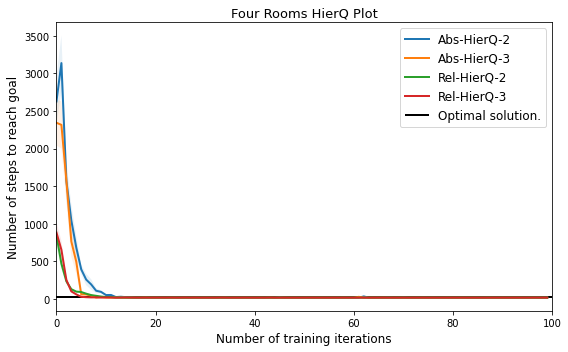

In [22]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1][4:], [r'Bin-Abs-HierQ-2', r'Bin-Abs-HierQ-3', r'Bin-Rel-HierQ-2', r'Bin-Rel-HierQ-3', 
                                       r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-HierQ-2', r'Rel-HierQ-3'][4:]):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(28, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 100])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

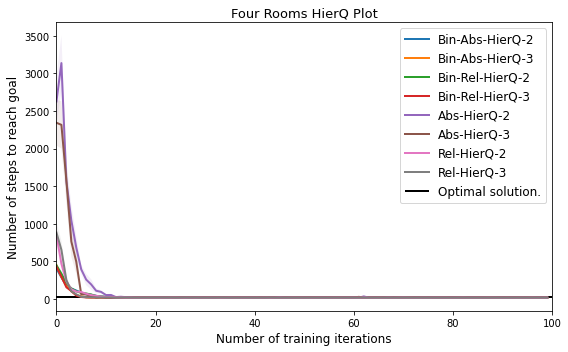

In [24]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Bin-Abs-HierQ-2', r'Bin-Abs-HierQ-3', r'Bin-Rel-HierQ-2', r'Bin-Rel-HierQ-3', 
                                       r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-HierQ-2', r'Rel-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(28, 0, 200, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 100])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

#### GridWorld

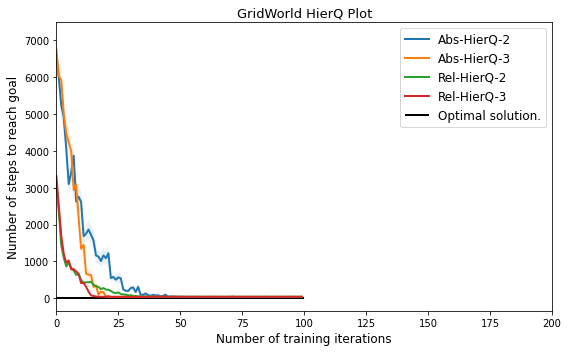

In [26]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1][4:],  [r'Bin-Abs-HierQ-2', r'Bin-Abs-HierQ-3', r'Bin-Rel-HierQ-2', r'Bin-Rel-HierQ-3', 
                                       r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-HierQ-2', r'Rel-HierQ-3'][4:]):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
# optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

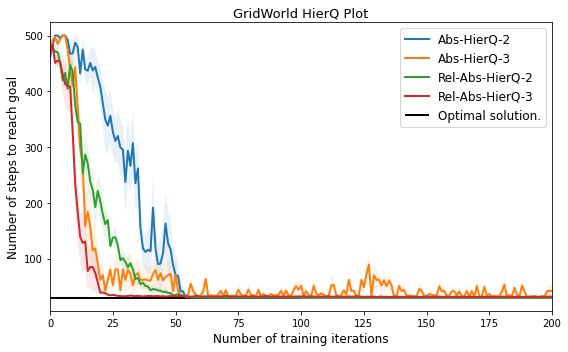

In [40]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1],  [r'Bin-Abs-HierQ-2', r'Bin-Abs-HierQ-3', r'Bin-Rel-HierQ-2', r'Bin-Rel-HierQ-3', 
                                       r'Abs-HierQ-2', r'Abs-HierQ-3', r'Rel-HierQ-2', r'Rel-HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(largegrid.unwrapped.maze.get_start_pos(), largegrid.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 100, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 200])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [140]:
agent = AgentShelve.retrieve(
        agent='HierQV2',
        keyword_arguments=dict(
            observation_shape=gridworld.observation_space.shape,
            n_actions=gridworld.action_space.n,
            n_levels=3,
            horizons=[3] * (3 - 1) + [200],
            lr=1, discount=1, epsilon=0.25, 
            universal_top=False, relative_goals=True, relative_actions=True
        ))
agent.set_goal(agent._get_index(gridworld.unwrapped.maze.get_end_pos()[0]))

In [141]:
np.ravel_multi_index([[0], [1]], (3, 3))

array([1], dtype=int64)

In [142]:
agent.train(gridworld, 100, True)

HierQ Training: 100%|████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.15it/s]
